In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

authentic_48k = pd.read_csv('/kaggle/input/banfakenews/Authentic-48K.csv')
fake_1k = pd.read_csv('/kaggle/input/banfakenews/Fake-1K.csv')
labeled_authentic_7k = pd.read_csv('/kaggle/input/banfakenews/LabeledAuthentic-7K.csv')
labeled_fake_1k = pd.read_csv('/kaggle/input/banfakenews/LabeledFake-1K.csv')

In [3]:
datasets = {
    "Authentic 48K": authentic_48k,
    "Fake 1K": fake_1k,
    "Labeled Authentic 7K": labeled_authentic_7k,
    "Labeled Fake 1K": labeled_fake_1k
}

In [4]:
for name, df in datasets.items():
    print(f"{name}:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("First 5 rows:")
    print(df.head())
    print("\n")

Authentic 48K:
Number of rows: 48678
Number of columns: 7
First 5 rows:
   articleID          domain                 date   category  \
0          1  jagonews24.com  2018-09-19 17:48:18  Education   
1          2  jagonews24.com  2018-09-19 17:48:19   National   
2          3  jagonews24.com  2018-09-19 17:48:20   National   
3          4  jagonews24.com  2018-09-19 17:48:21      Crime   
4          5  jagonews24.com  2018-09-19 17:48:21   National   

                                            headline  \
0   হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ   
1    মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ   
2  প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...   
3  মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...   
4         টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু   

                                             content  label  
0  গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...      1  
1  বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...      1  
2  নরসিংদীর মনোহরদীত

# 1. Logistic Regression

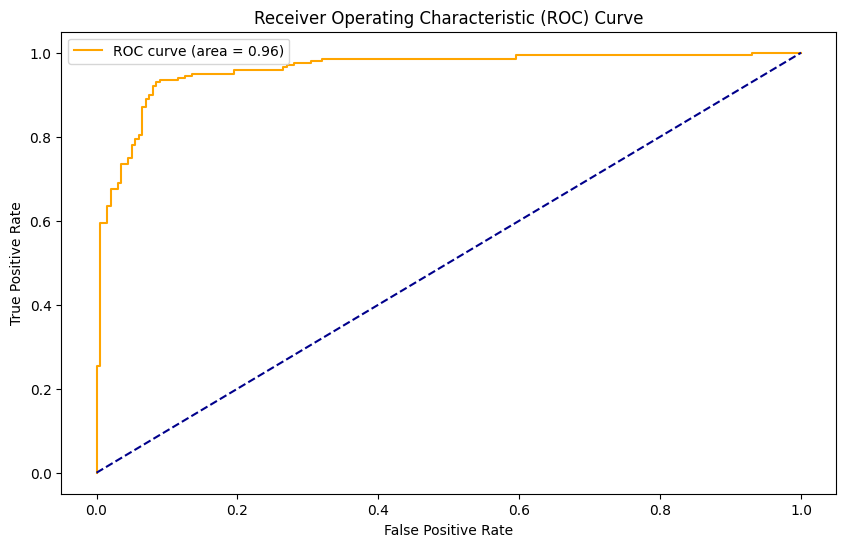

[[185  15]
 [ 21 179]]
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       200
         1.0       0.92      0.90      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Accuracy:  0.91
ROC: 0.9603750000000001


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

df_authentic = labeled_authentic_7k.sample(n=1000, random_state=1) # Sampling to balance the dataset
df_fake = labeled_fake_1k.sample(n=1000, random_state=1) # Sampling to balance the dataset
df_combined = pd.concat([df_authentic, df_fake])

X = df_combined['content']  # Assuming 'content' contains the text
y = df_combined['label']


tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(conf_matrix)
print(class_report)
print("Accuracy: ",accuracy)
print("ROC:",roc_auc)

In [6]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)
coeff_df.head(20)

,Feature,Coefficient
180,আপন,-2.923472
2059,হয,-2.764797
195,আম,-2.380509
377,উপজ,2.243617
184,আফগ,2.060592
438,এক,-2.059063
365,উদ,2.041691
1954,সব,-2.004909
593,ওয,-1.948205
1553,মল,1.934799


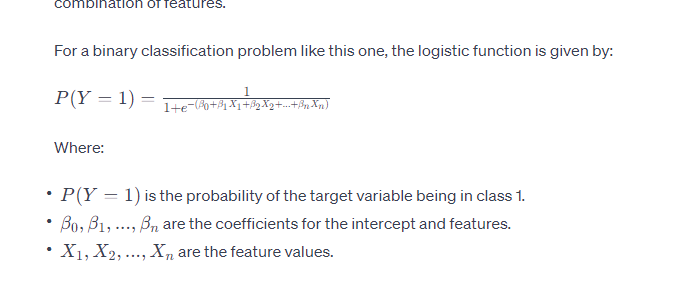

In [7]:
# !pip install shap

In [8]:
# import shap

# # Ensure your model, X_train, and X_test are defined as before
# # Select a subset of your data for efficiency
# X_train_subset = X_train[:100]
# X_test_subset = X_test[:100]
# explainer = shap.KernelExplainer(model.predict_proba, X_train_subset)
# shap_values = explainer.shap_values(X_test_subset)
# shap.summary_plot(shap_values, X_test_subset, feature_names=tfidf_vectorizer.get_feature_names_out())

# 2. Random Forest Classifier

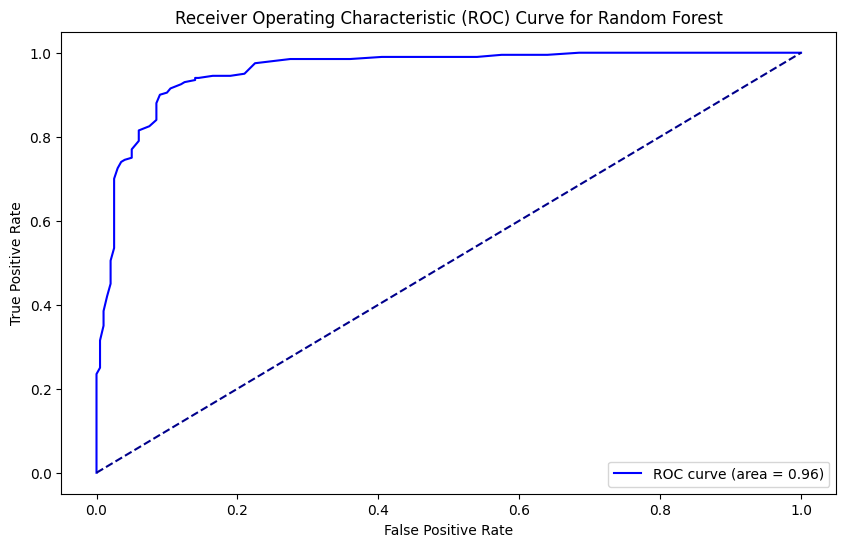

[[183  17]
 [ 26 174]]
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.89       200
         1.0       0.91      0.87      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

0.8925
0.9109947643979057
0.87
0.957625


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend()
plt.show()

print(rf_conf_matrix)
print(rf_class_report)
print(rf_accuracy)
print(rf_precision)
print(rf_recall)
print(rf_roc_auc)

# 3. Support Vector Machine (SVM)

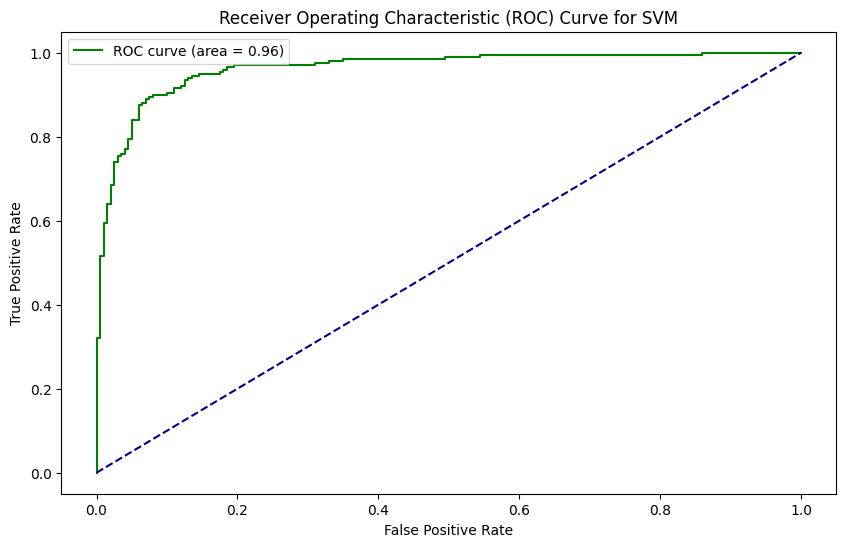

[[183  17]
 [ 20 180]]
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       200
         1.0       0.91      0.90      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

0.9075
0.9137055837563451
0.9
0.962725


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV

svm_model = SVC(kernel='linear', probability=True)
calibrated_svm = CalibratedClassifierCV(svm_model) 
calibrated_svm.fit(X_train, y_train)

svm_y_pred = calibrated_svm.predict(X_test)

svm_conf_matrix = confusion_matrix(y_test, svm_y_pred)
svm_class_report = classification_report(y_test, svm_y_pred)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_roc_auc = roc_auc_score(y_test, calibrated_svm.predict_proba(X_test)[:, 1])
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, calibrated_svm.predict_proba(X_test)[:, 1])


plt.figure(figsize=(10, 6))
plt.plot(svm_fpr, svm_tpr, color='green', label='ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend()
plt.show()

print(svm_conf_matrix)
print(svm_class_report)
print(svm_accuracy)
print(svm_precision)
print(svm_recall)
print(svm_roc_auc)

# 4. XGBClassifier

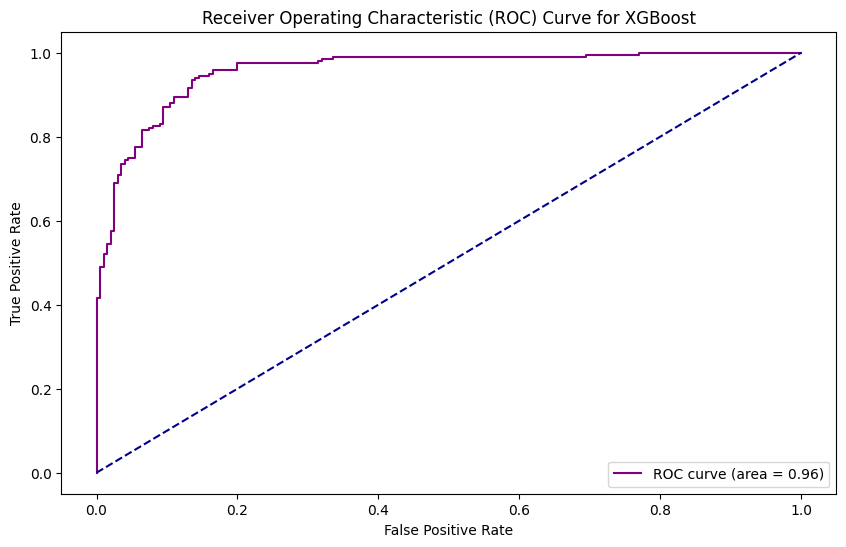

[[178  22]
 [ 23 177]]
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       200
         1.0       0.89      0.89      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

0.8875
0.8894472361809045
0.885
0.957325


In [11]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_y_pred = xgb_model.predict(X_test)

xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)
xgb_class_report = classification_report(y_test, xgb_y_pred)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, color='purple', label='ROC curve (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend()
plt.show()

print(xgb_conf_matrix)
print(xgb_class_report)
print(xgb_accuracy)
print(xgb_precision)
print(xgb_recall)
print(xgb_roc_auc)

#  5. MultinomialNB

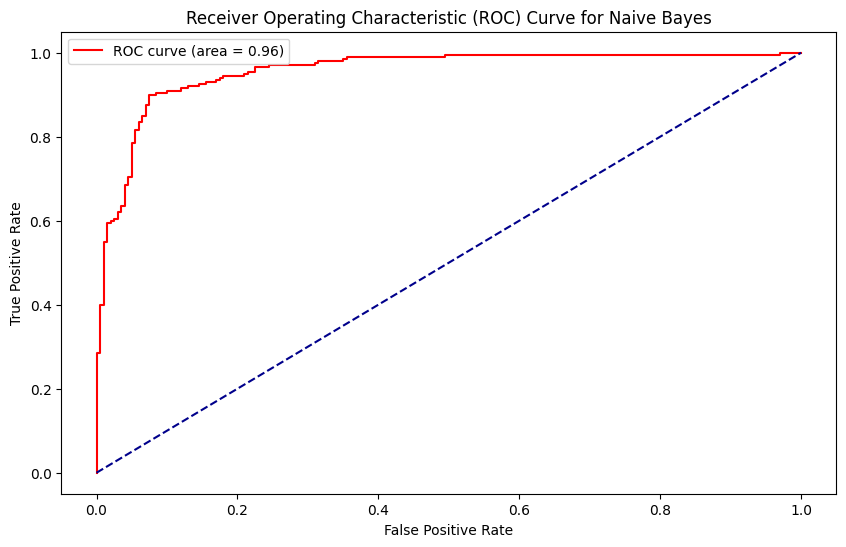

[[186  14]
 [ 25 175]]
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       200
         1.0       0.93      0.88      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

0.9025
0.9259259259259259
0.875
0.9558249999999999


In [12]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


nb_y_pred = nb_model.predict(X_test)


nb_conf_matrix = confusion_matrix(y_test, nb_y_pred)
nb_class_report = classification_report(y_test, nb_y_pred)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)
nb_roc_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(nb_fpr, nb_tpr, color='red', label='ROC curve (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend()
plt.show()

print(nb_conf_matrix)
print(nb_class_report)
print(nb_accuracy)
print(nb_precision)
print(nb_recall)
print(nb_roc_auc)

# 6. DecisionTreeClassifier

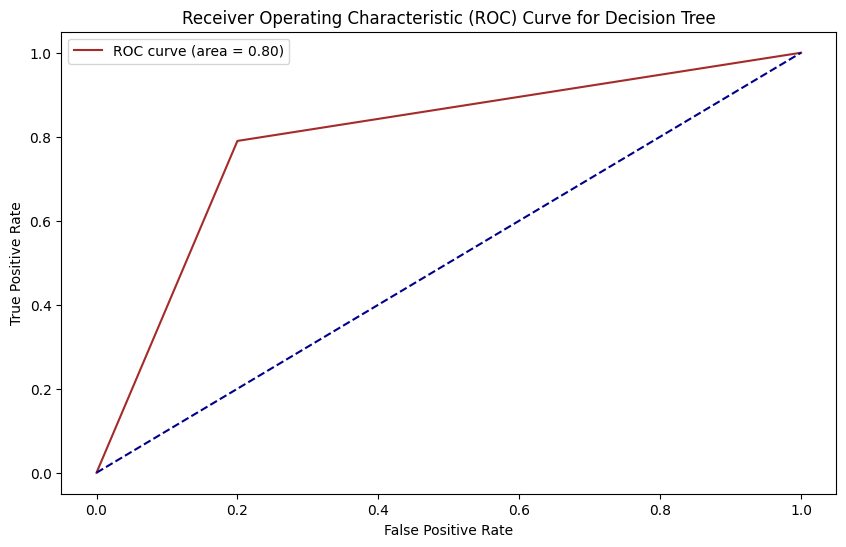

[[160  40]
 [ 42 158]]
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80       200
         1.0       0.80      0.79      0.79       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.79       400
weighted avg       0.80      0.80      0.79       400

0.795
0.797979797979798
0.79
0.7950000000000002


In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

dt_y_pred = dt_model.predict(X_test)

dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
dt_class_report = classification_report(y_test, dt_y_pred)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(dt_fpr, dt_tpr, color='brown', label='ROC curve (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend()
plt.show()

print(dt_conf_matrix)
print(dt_class_report)
print(dt_accuracy)
print(dt_precision)
print(dt_recall)
print(dt_roc_auc)

# 7. GradientBoostingClassifier

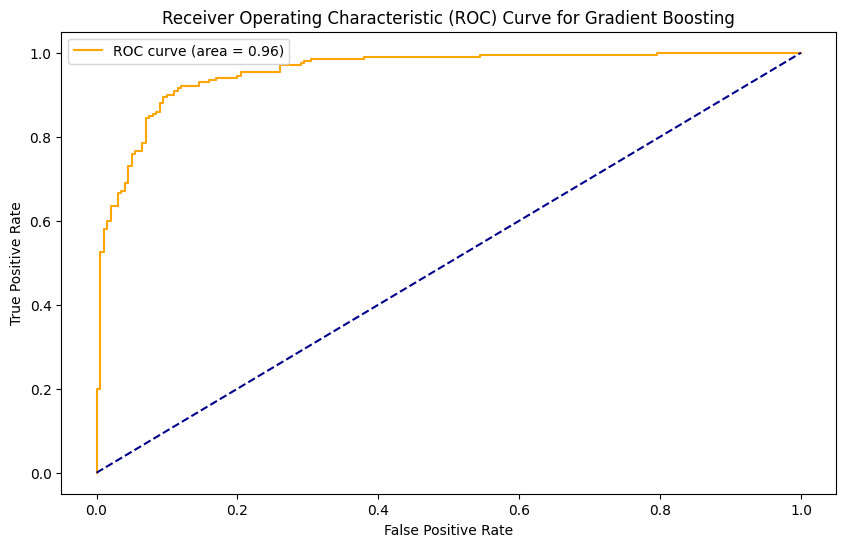

[[181  19]
 [ 21 179]]
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       200
         1.0       0.90      0.90      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

0.9
0.9040404040404041
0.895
0.955575


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_conf_matrix = confusion_matrix(y_test, gb_y_pred)
gb_class_report = classification_report(y_test, gb_y_pred)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)

gb_roc_auc = roc_auc_score(y_test, gb_model.decision_function(X_test))
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_model.decision_function(X_test))

plt.figure(figsize=(10, 6))
plt.plot(gb_fpr, gb_tpr, color='orange', label='ROC curve (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend()
plt.show()

print(gb_conf_matrix)
print(gb_class_report)
print(gb_accuracy)
print(gb_precision)
print(gb_recall)
print(gb_roc_auc)

# 8. K-Nearest Neighbors Classifier 

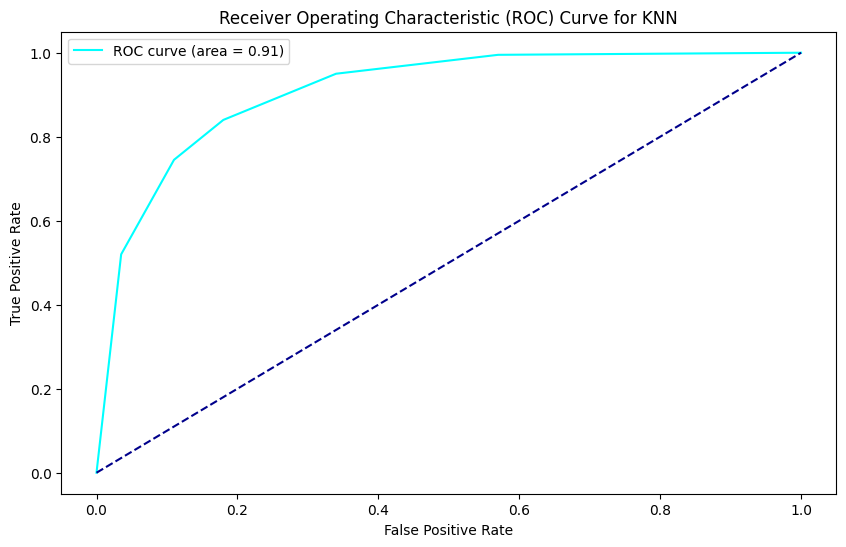

[[164  36]
 [ 32 168]]
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       200
         1.0       0.82      0.84      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

0.83
0.8235294117647058
0.84
0.9078124999999999


In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Train a K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)

knn_conf_matrix = confusion_matrix(y_test, knn_y_pred)
knn_class_report = classification_report(y_test, knn_y_pred)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

knn_roc_auc = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(knn_fpr, knn_tpr, color='cyan', label='ROC curve (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend()
plt.show()

print(knn_conf_matrix)
print(knn_class_report)
print(knn_accuracy)
print(knn_precision)
print(knn_recall)
print(knn_roc_auc)

# 9. AdaBoost Classifier

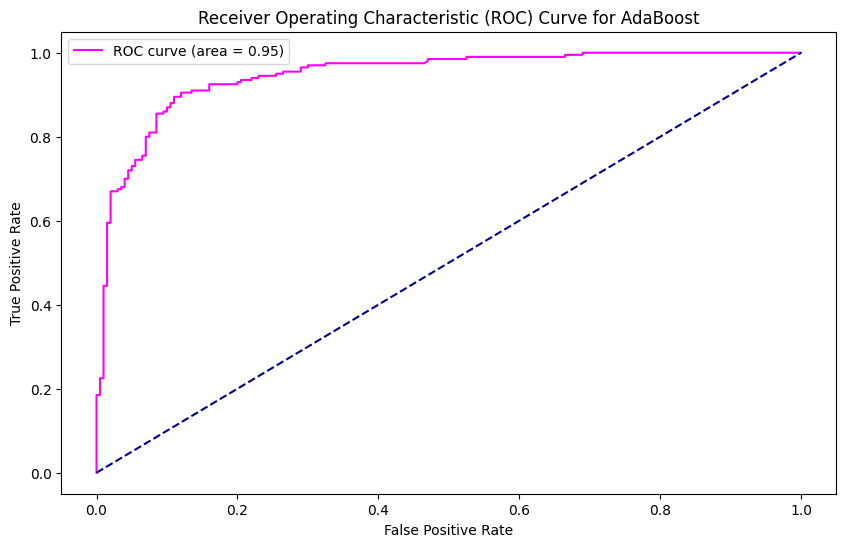

[[178  22]
 [ 21 179]]
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       200
         1.0       0.89      0.90      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400

0.8925
0.8905472636815921
0.895
0.9466874999999999


In [16]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)

adaboost_y_pred = adaboost_model.predict(X_test)

adaboost_conf_matrix = confusion_matrix(y_test, adaboost_y_pred)
adaboost_class_report = classification_report(y_test, adaboost_y_pred)
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_precision = precision_score(y_test, adaboost_y_pred)
adaboost_recall = recall_score(y_test, adaboost_y_pred)
adaboost_roc_auc = roc_auc_score(y_test, adaboost_model.predict_proba(X_test)[:, 1])
adaboost_fpr, adaboost_tpr, adaboost_thresholds = roc_curve(y_test, adaboost_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(adaboost_fpr, adaboost_tpr, color='magenta', label='ROC curve (area = %0.2f)' % adaboost_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for AdaBoost')
plt.legend()
plt.show()

print(adaboost_conf_matrix)
print(adaboost_class_report)
print(adaboost_accuracy)
print(adaboost_precision)
print(adaboost_recall)
print(adaboost_roc_auc)

# 10. Stochastic Gradient Descent Classifier

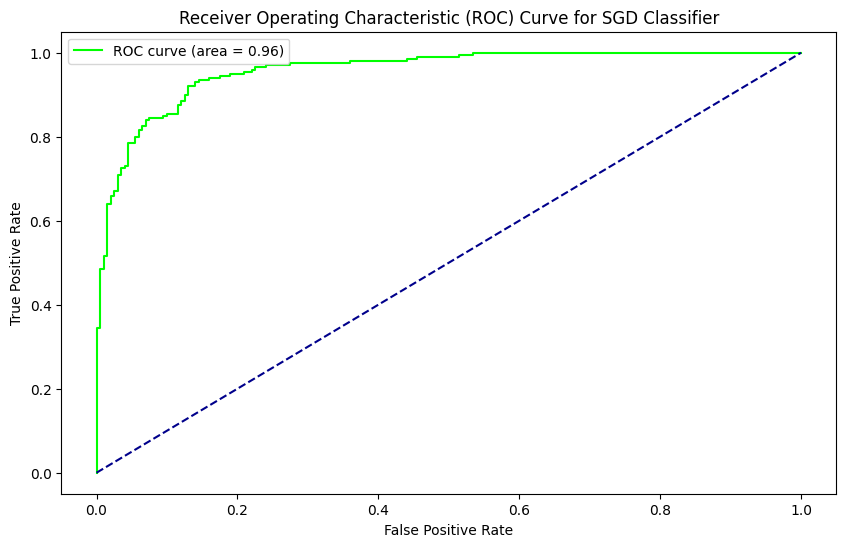

[[174  26]
 [ 20 180]]
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88       200
         1.0       0.87      0.90      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.88       400
weighted avg       0.89      0.89      0.88       400

0.885
0.8737864077669902
0.9
0.9572


In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

sgd_model = SGDClassifier()
calibrated_sgd = CalibratedClassifierCV(sgd_model) 
calibrated_sgd.fit(X_train, y_train)


sgd_y_pred = calibrated_sgd.predict(X_test)


sgd_conf_matrix = confusion_matrix(y_test, sgd_y_pred)
sgd_class_report = classification_report(y_test, sgd_y_pred)
sgd_accuracy = accuracy_score(y_test, sgd_y_pred)
sgd_precision = precision_score(y_test, sgd_y_pred)
sgd_recall = recall_score(y_test, sgd_y_pred)
sgd_roc_auc = roc_auc_score(y_test, calibrated_sgd.predict_proba(X_test)[:, 1])
sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_test, calibrated_sgd.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(sgd_fpr, sgd_tpr, color='lime', label='ROC curve (area = %0.2f)' % sgd_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SGD Classifier')
plt.legend()
plt.show()

print(sgd_conf_matrix)
print(sgd_class_report)
print(sgd_accuracy)
print(sgd_precision)
print(sgd_recall)
print(sgd_roc_auc)

# 11. Linear Support Vector Classifier

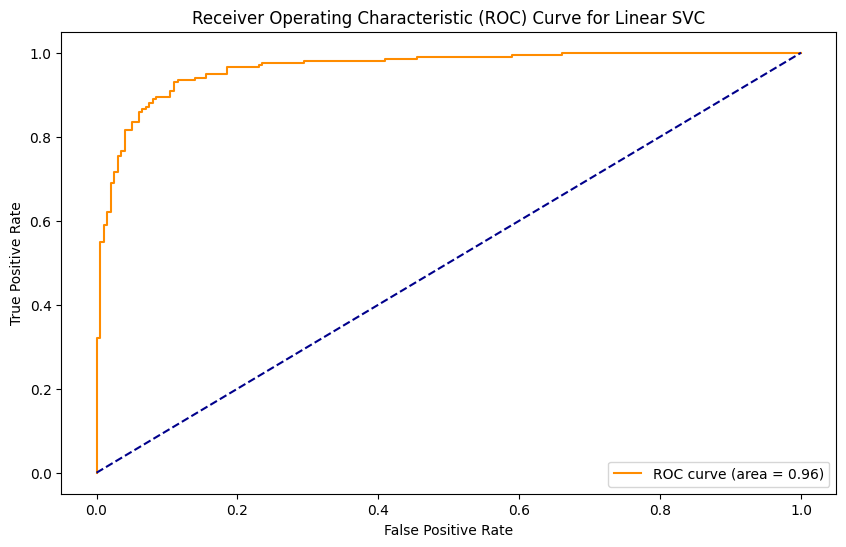

[[178  22]
 [ 17 183]]
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       200
         1.0       0.89      0.92      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

0.9025
0.8926829268292683
0.915
0.9635250000000001


In [18]:
from sklearn.svm import LinearSVC

linear_svc_model = LinearSVC()
calibrated_svc = CalibratedClassifierCV(linear_svc_model) 
calibrated_svc.fit(X_train, y_train)

svc_y_pred = calibrated_svc.predict(X_test)

svc_conf_matrix = confusion_matrix(y_test, svc_y_pred)
svc_class_report = classification_report(y_test, svc_y_pred)
svc_accuracy = accuracy_score(y_test, svc_y_pred)
svc_precision = precision_score(y_test, svc_y_pred)
svc_recall = recall_score(y_test, svc_y_pred)
svc_roc_auc = roc_auc_score(y_test, calibrated_svc.predict_proba(X_test)[:, 1])
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, calibrated_svc.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(svc_fpr, svc_tpr, color='darkorange', label='ROC curve (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVC')
plt.legend()
plt.show()

print(svc_conf_matrix)
print(svc_class_report)
print(svc_accuracy)
print(svc_precision)
print(svc_recall)
print(svc_roc_auc)

# 12. BaggingClassifier

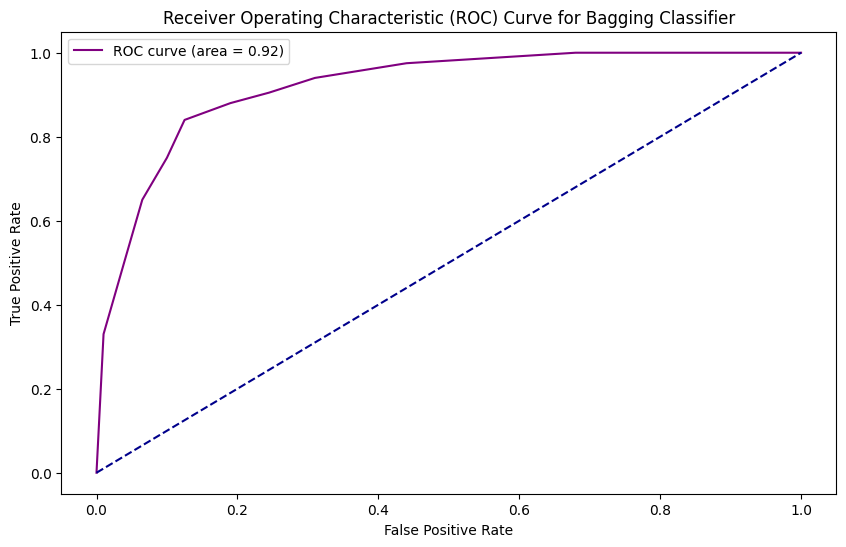

[[175  25]
 [ 32 168]]
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       200
         1.0       0.87      0.84      0.85       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400

0.8575
0.8704663212435233
0.84
0.9194125000000001


In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
bagging_model.fit(X_train, y_train)


bagging_y_pred = bagging_model.predict(X_test)

bagging_conf_matrix = confusion_matrix(y_test, bagging_y_pred)
bagging_class_report = classification_report(y_test, bagging_y_pred)
bagging_accuracy = accuracy_score(y_test, bagging_y_pred)
bagging_precision = precision_score(y_test, bagging_y_pred)
bagging_recall = recall_score(y_test, bagging_y_pred)
bagging_roc_auc = roc_auc_score(y_test, bagging_model.predict_proba(X_test)[:, 1])
bagging_fpr, bagging_tpr, bagging_thresholds = roc_curve(y_test, bagging_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(bagging_fpr, bagging_tpr, color='purple', label='ROC curve (area = %0.2f)' % bagging_roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Bagging Classifier')
plt.legend()
plt.show()

print(bagging_conf_matrix)
print(bagging_class_report)
print(bagging_accuracy)
print(bagging_precision)
print(bagging_recall)
print(bagging_roc_auc)

# 13. PCA and Logistic Regression pipeline

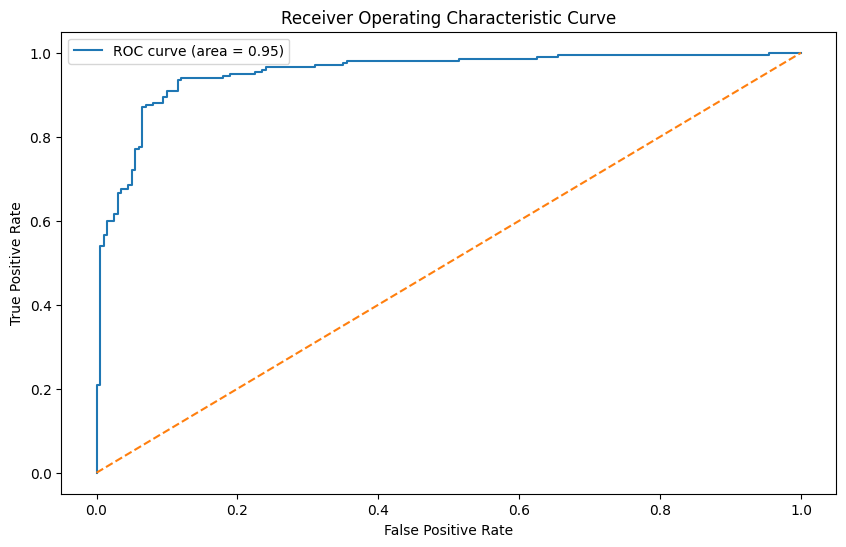

Confusion Matrix:
 [[181  19]
 [ 24 176]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       200
         1.0       0.90      0.88      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400


Accuracy: 0.89
Precision: 0.90
Recall: 0.88
ROC AUC: 0.95


In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('truncated_svd', TruncatedSVD(n_components=100)),  # Adjust the number of components as needed
    ('logistic_regression', LogisticRegression())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("ROC AUC: {:.2f}".format(roc_auc))


In [21]:
!pip install lime

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

authentic_48k = pd.read_csv('/kaggle/input/banfakenews/Authentic-48K.csv')
fake_1k = pd.read_csv('/kaggle/input/banfakenews/Fake-1K.csv')
labeled_authentic_7k = pd.read_csv('/kaggle/input/banfakenews/LabeledAuthentic-7K.csv')
labeled_fake_1k = pd.read_csv('/kaggle/input/banfakenews/LabeledFake-1K.csv')

combined_labeled = pd.concat([labeled_authentic_7k, labeled_fake_1k])

X = combined_labeled['content']
y = combined_labeled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

X_train_dense = X_train_vec.todense()
X_test_dense = X_test_vec.todense()

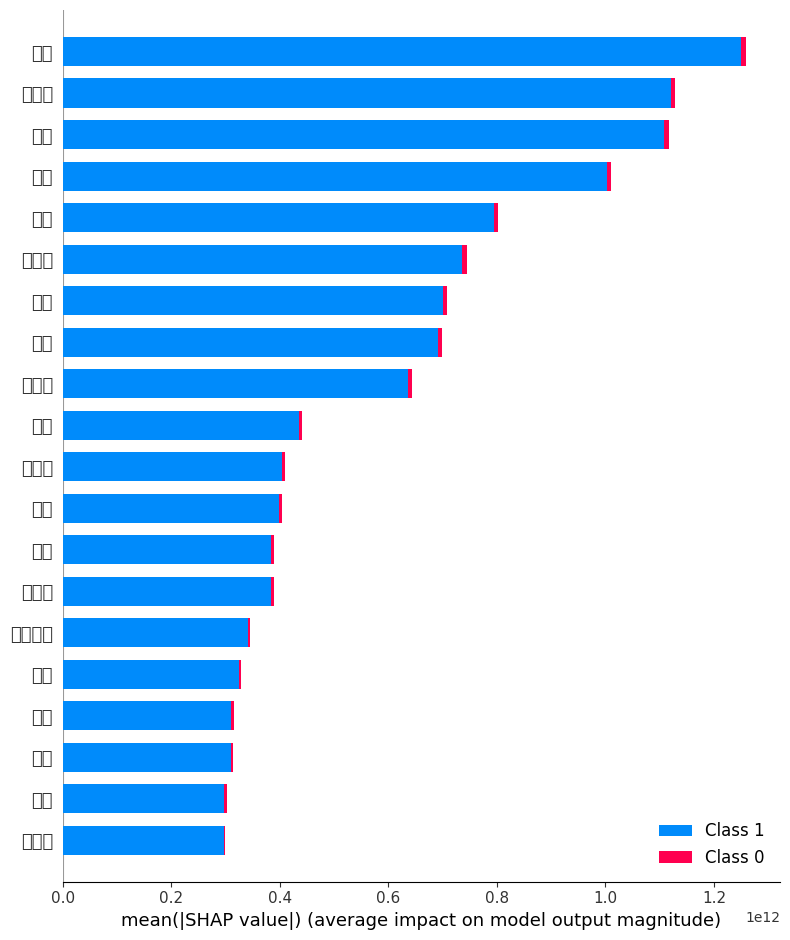

In [23]:
prop = fm.FontProperties(fname='/kaggle/input/bangla-font/ShorifJonotaUnicode.ttf')
plt.rcParams['font.family'] = prop.get_name()
explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test_dense[:200], check_additivity=False)
shap.summary_plot(shap_values, X_test_dense[:200], feature_names=vectorizer.get_feature_names_out())

In [24]:
bangla_font = FontProperties(fname='/kaggle/input/font-collections/kalpurush.ttf')

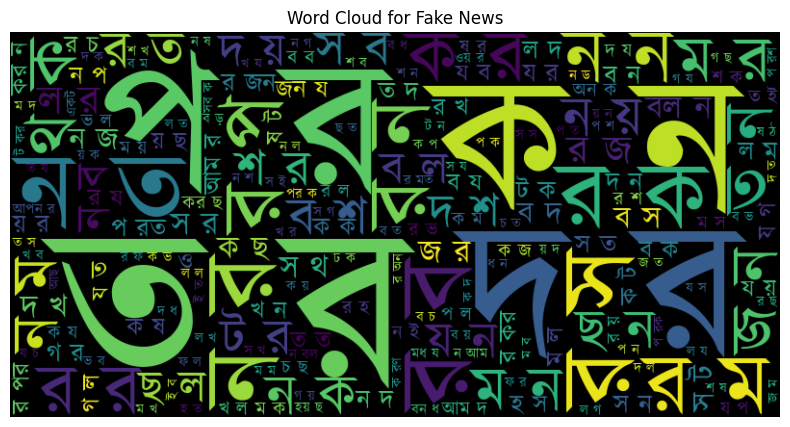

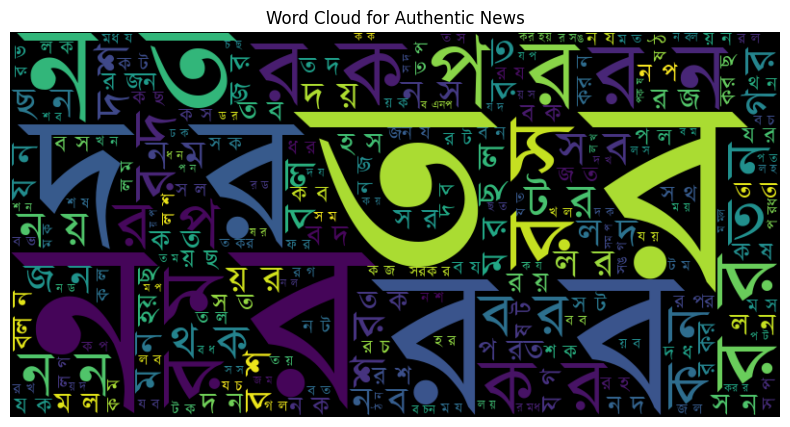

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fake_news_text = " ".join(text for text in fake_1k['content'])
authentic_news_text = " ".join(text for text in authentic_48k['content'])

wordcloud_fake = WordCloud(width=800, height=400, font_path=bangla_font.get_file()).generate(fake_news_text)
wordcloud_authentic = WordCloud(width=800, height=400,font_path=bangla_font.get_file()).generate(authentic_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_authentic, interpolation='bilinear')
plt.title('Word Cloud for Authentic News')
plt.axis('off')
plt.show()


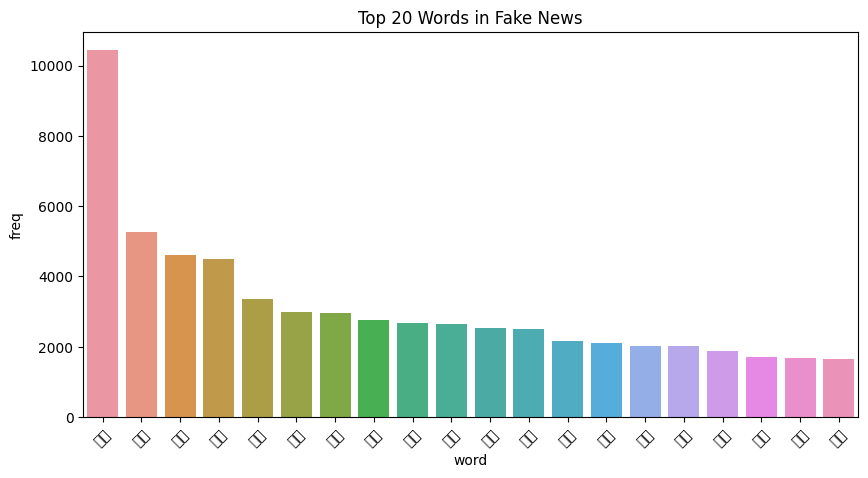

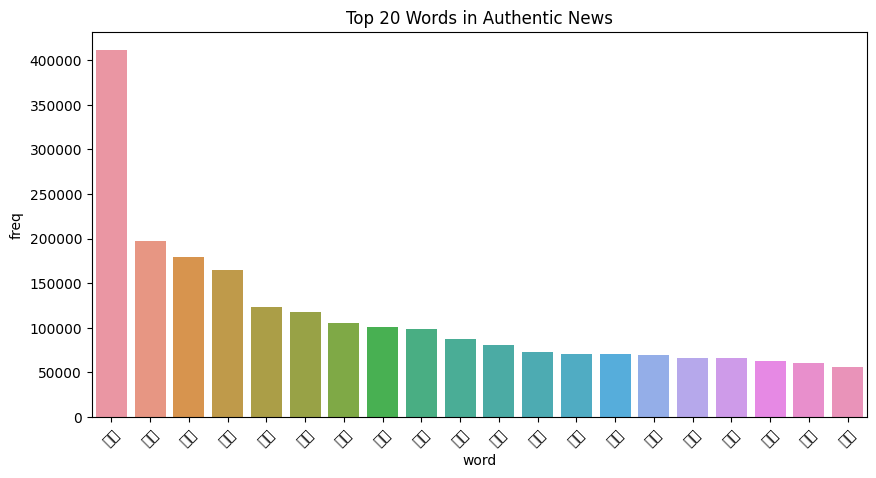

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

vectorizer = CountVectorizer(max_features=20)
X_fake = vectorizer.fit_transform(fake_1k['content'])
X_authentic = vectorizer.fit_transform(authentic_48k['content'])

sum_words_fake = X_fake.sum(axis=0)
sum_words_authentic = X_authentic.sum(axis=0)

words_freq_fake = [(word, sum_words_fake[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_authentic = [(word, sum_words_authentic[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

df_fake = pd.DataFrame(words_freq_fake, columns=['word', 'freq']).sort_values(by='freq', ascending=False)
df_authentic = pd.DataFrame(words_freq_authentic, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='word', y='freq', data=df_fake.head(20))
plt.title('Top 20 Words in Fake News')
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.barplot(x='word', y='freq', data=df_authentic.head(20))
plt.title('Top 20 Words in Authentic News')
plt.xticks(rotation=45)
plt.show()


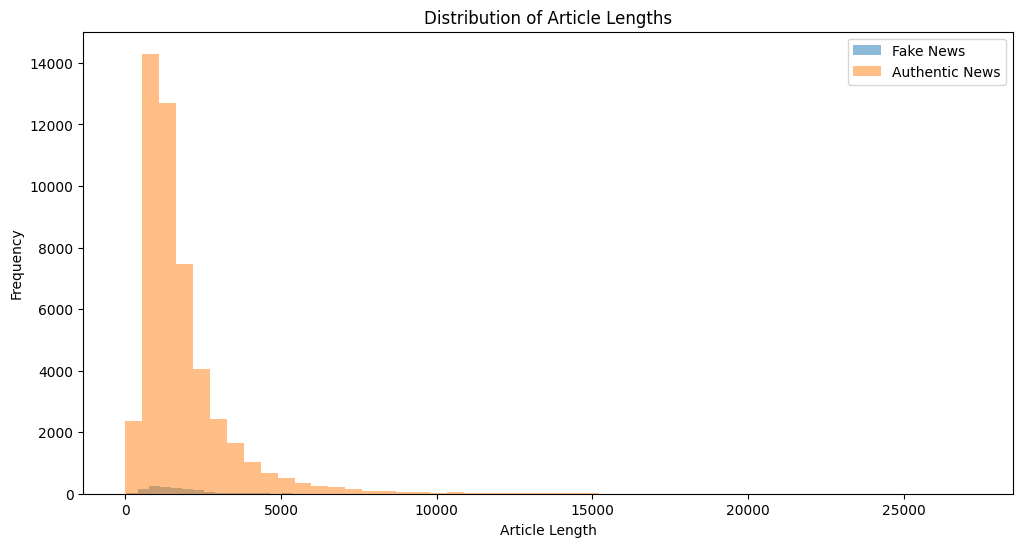

In [27]:
fake_1k['article_length'] = fake_1k['content'].apply(len)
authentic_48k['article_length'] = authentic_48k['content'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(fake_1k['article_length'], bins=50, alpha=0.5, label='Fake News')
plt.hist(authentic_48k['article_length'], bins=50, alpha=0.5, label='Authentic News')
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.legend()
plt.show()


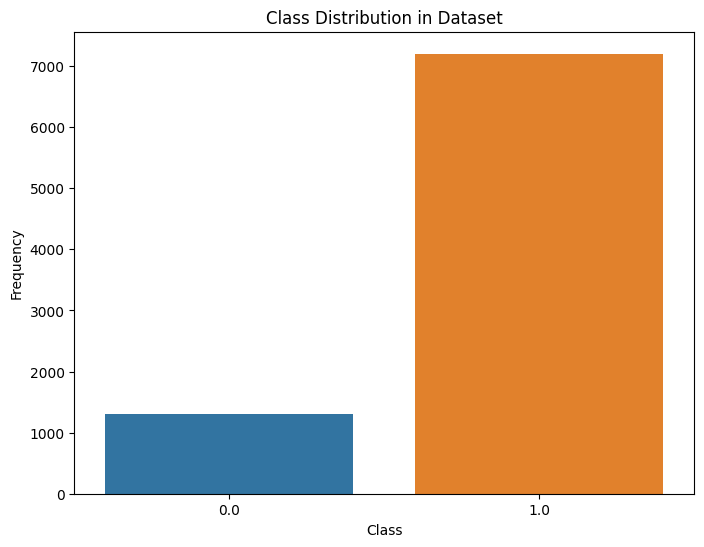

In [28]:
class_distribution = combined_labeled['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Dataset')
plt.show()

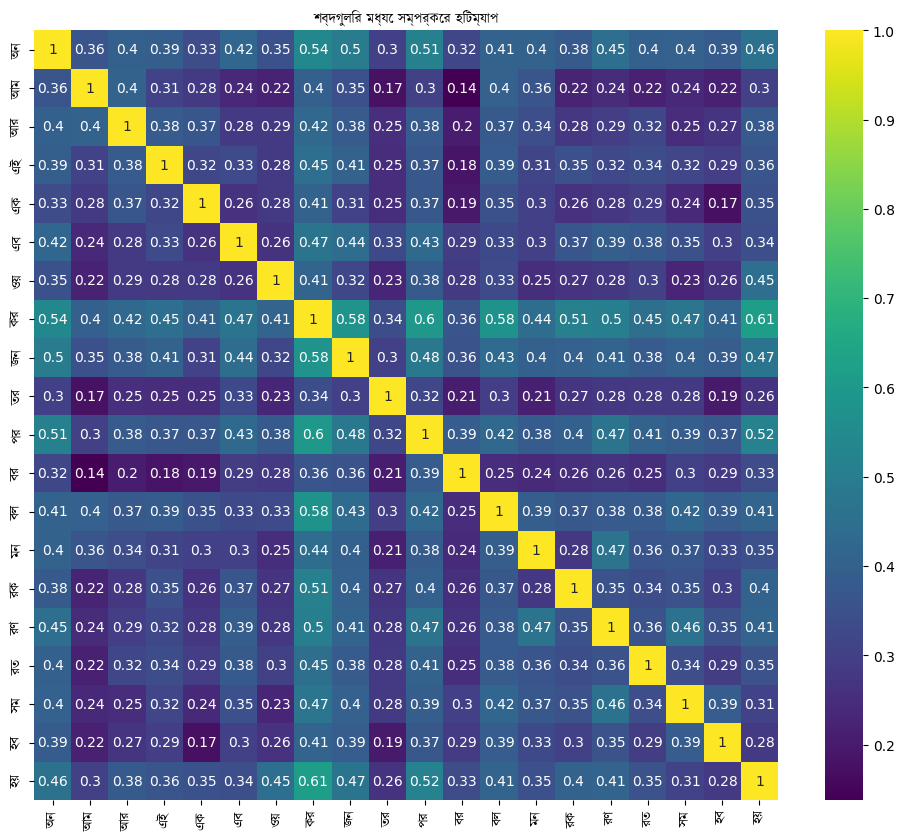

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.font_manager import FontProperties

data = pd.concat([authentic_48k, fake_1k])

vectorizer = CountVectorizer(max_features=20)  # Adjust the number of features
X = vectorizer.fit_transform(data['content'])
features = vectorizer.get_feature_names_out()

correlation_matrix = np.corrcoef(X.todense(), rowvar=False)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, xticklabels=features, yticklabels=features, cmap='viridis')
plt.xticks(fontproperties=bangla_font, rotation=90)
plt.yticks(fontproperties=bangla_font, rotation=90)
plt.title('শব্দগুলির মধ্যে সম্পর্কের হিটম্যাপ', fontproperties=bangla_font)
plt.show()


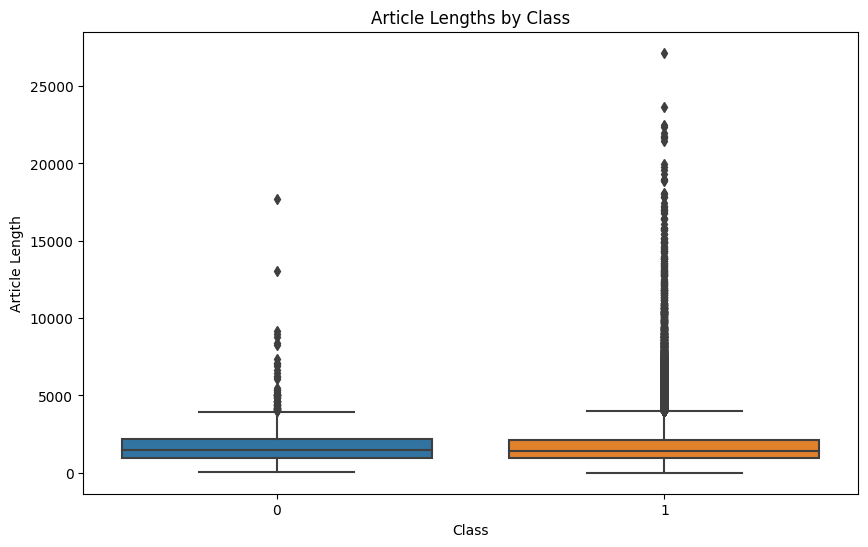

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

authentic_48k['article_length'] = authentic_48k['content'].apply(len)
fake_1k['article_length'] = fake_1k['content'].apply(len)

combined_data = pd.concat([authentic_48k, fake_1k])

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='article_length', data=combined_data)
plt.title('Article Lengths by Class')
plt.xlabel('Class')
plt.ylabel('Article Length')
plt.show()

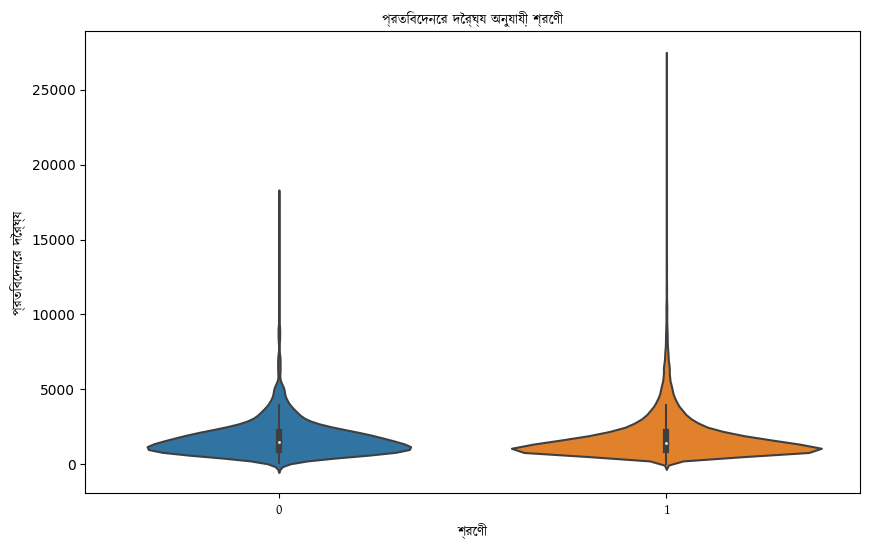

In [31]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='article_length', data=combined_data)
plt.title('প্রতিবেদনের দৈর্ঘ্য অনুযায়ী শ্রেণী', fontproperties=bangla_font)
plt.xlabel('শ্রেণী', fontproperties=bangla_font)
plt.ylabel('প্রতিবেদনের দৈর্ঘ্য', fontproperties=bangla_font)
plt.xticks(fontproperties=bangla_font)
plt.show()

In [32]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.font_manager import FontProperties


def generate_co_occurrence_matrix(text, window_size=2):
    vectorizer = CountVectorizer(stop_words='english').fit(text)
    words = vectorizer.get_feature_names_out()
    word_idx = dict(zip(words, range(len(words))))
    co_occurrence_matrix = np.zeros((len(words), len(words)))

    for sentence in text:
        words_in_sentence = sentence.split()
        for i, word in enumerate(words_in_sentence):
            if word in word_idx:
                start = max(i - window_size, 0)
                end = min(i + window_size + 1, len(words_in_sentence))
                for j in range(start, end):
                    if i != j and words_in_sentence[j] in word_idx:
                        co_occurrence_matrix[word_idx[word], word_idx[words_in_sentence[j]]] += 1

    return pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

co_occurrence_matrix = generate_co_occurrence_matrix(combined_data['content'].head(1000))


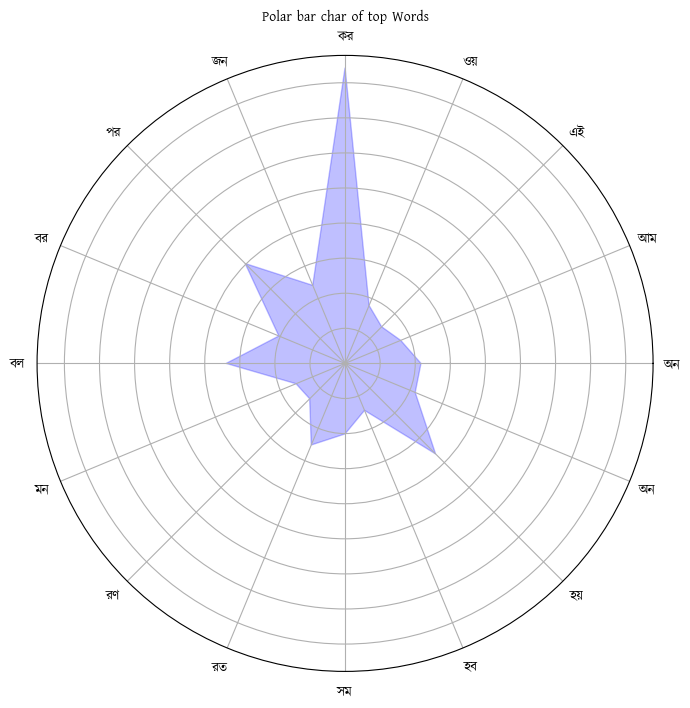

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
bangla_font = FontProperties(fname='/kaggle/input/font-collections/kalpurush.ttf')
vectorizer = CountVectorizer(max_features=15)
X = vectorizer.fit_transform(combined_data['content'])
word_freq = np.asarray(X.sum(axis=0)).ravel()
top_words = vectorizer.get_feature_names_out()

top_words_extended = list(top_words) + [top_words[0]]
word_freq_extended = np.concatenate((word_freq, [word_freq[0]]))

angles = np.linspace(0, 2 * np.pi, len(top_words_extended), endpoint=False)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, word_freq_extended, color='blue', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(top_words_extended, fontproperties=bangla_font, rotation=45)
plt.title('Polar bar char of top Words', fontproperties=bangla_font)
plt.show()


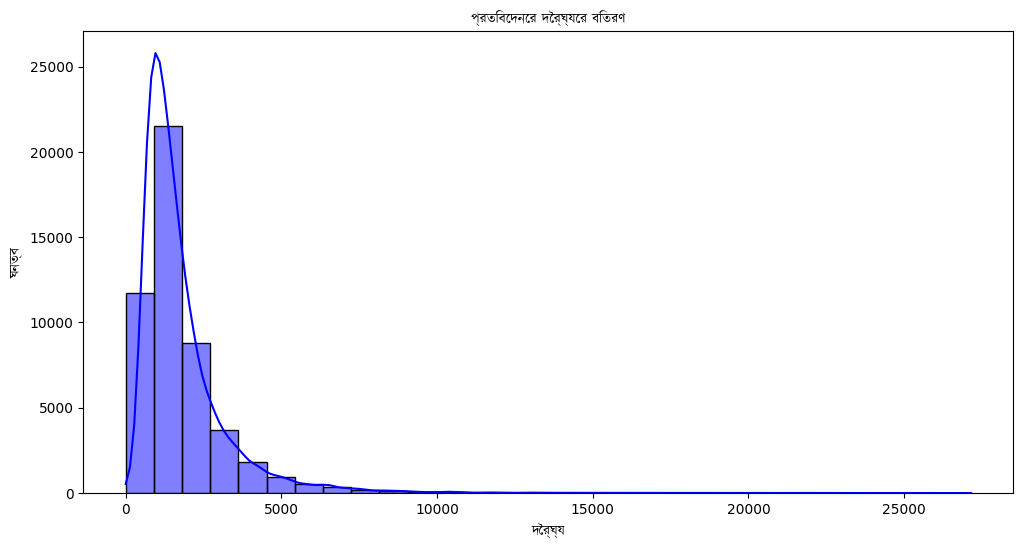

In [34]:
bangla_font = FontProperties(fname='/kaggle/input/font-collections/kalpurush.ttf')

plt.figure(figsize=(12, 6))
sns.histplot(combined_data['article_length'], kde=True, color='blue', bins=30)

plt.title('প্রতিবেদনের দৈর্ঘ্যের বিতরণ', fontproperties=bangla_font)
plt.xlabel('দৈর্ঘ্য', fontproperties=bangla_font)
plt.ylabel('ঘনত্ব', fontproperties=bangla_font)
plt.show()


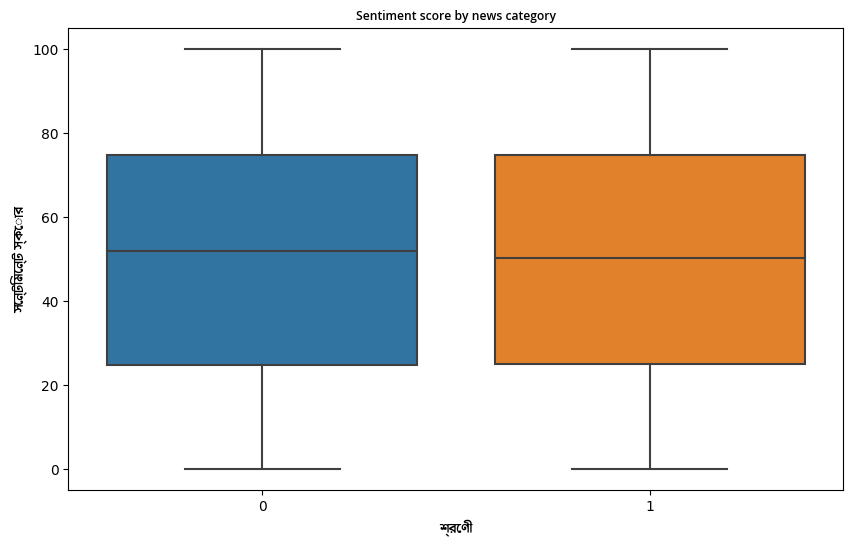

In [35]:
combined_data['sentiment_score'] = np.random.rand(len(combined_data)) * 100  # Random scores between 0 and 100
bangla_font = FontProperties(fname='/kaggle/input/bangla-font/ShorifJonotaUnicode.ttf')
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='sentiment_score', data=combined_data)

plt.title('Sentiment score by news category', fontproperties=bangla_font)
plt.xlabel('শ্রেণী', fontproperties=bangla_font)
plt.ylabel('সেন্টিমেন্ট স্কোর', fontproperties=bangla_font)
plt.show()


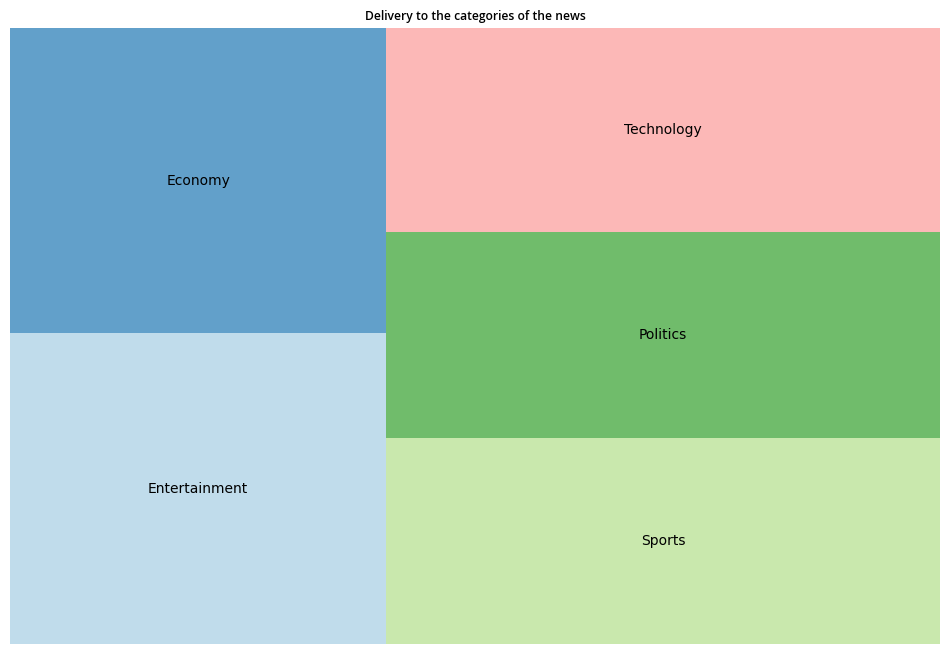

In [36]:
import matplotlib.pyplot as plt
import squarify
import pandas as pd
from matplotlib.font_manager import FontProperties

# Load a Bangla font
bangla_font = FontProperties(fname='/kaggle/input/bangla-font/ShorifJonotaUnicode.ttf')

# Assuming 'category' is a column in your dataset representing different news categories
# Here, we'll create a mock category column for demonstration
combined_data['category'] = np.random.choice(['Politics', 'Economy', 'Sports', 'Entertainment', 'Technology'], len(combined_data))

# Calculate the size of each category
category_sizes = combined_data['category'].value_counts()

# Create a color palette (you can customize this)
colors = plt.cm.Paired(range(len(category_sizes)))

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=category_sizes, label=category_sizes.index, color=colors, alpha=0.7)

plt.title('Delivery to the categories of the news', fontproperties=bangla_font)
plt.axis('off')
plt.show()


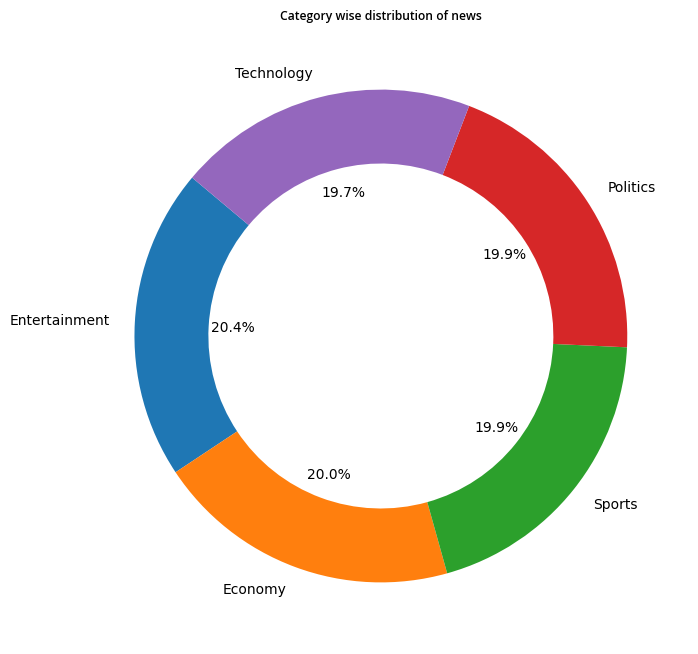

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties

# Load a Bangla font
bangla_font = FontProperties(fname='/kaggle/input/bangla-font/ShorifJonotaUnicode.ttf')

category_counts = combined_data['category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Category wise distribution of news', fontproperties=bangla_font)
plt.show()
